<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
درخواست کارفرمایان</font>
</h1>


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
لود کردن داده و کتابخانه های لازم
</h2>


In [3]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from urllib.parse import quote_plus
from jdatetime import datetime
from scipy.stats import ttest_ind
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import RandomForestRegressor
import re
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

file_dir = "sales_data.csv"
file_dir2 = "dollar_price.csv"
file_dir3 = "country-cities-data.csv"
pd.set_option("display.max_colwidth", None)

In [ ]:
# li = df["Order_Date"].str.split("-").str[0]
# li.unique()

# test = df[df["Model_Name"] == "Vostro 3568"]
# test = test[
#     [
#         # "Manufacturer",
#         "Model_Name",
#         # "Category",
#         "Screen_Size",
#         "Screen",
#         "CPU",
#         "GPU",
#         # "RAM",
#         "Storage",
#         # "OS",
#         # "OS_Version",
#         "Weight",
#     ]
# ]
# test = test.drop_duplicates()

# df_products[df_products["Model_Name"] == "Vostro 3568"]

# محاسبه نسبت تخفیف به تعداد فروخته‌شده بر اساس شهر
# discount_to_sales_ratio = df_temp.groupby("Branch").apply(
#     lambda x: x["Discount"].sum() / x["Quantity"].sum()
# )

## Create DataFrame

In [3]:
df = pd.read_csv(file_dir, low_memory=False)
df["Screen_Size"] = df["Screen_Size"].str.replace('"', "").astype(float)
df["RAM"] = df["RAM"].str.replace("GB", "").astype(int)
df["Weight"] = df["Weight"].replace(["kgs", "kg"], "", regex=True).astype(float)

df["Date_Shamsi"] = df["Order_Date"].copy()
df["Order_Date"] = df["Order_Date"].apply(
    lambda x: datetime.strptime(x, "%Y-%m-%d").togregorian()
)

df_dollar_price = pd.read_csv(file_dir2, index_col=[0])
df_dollar_price["miladi"] = pd.to_datetime(df_dollar_price["miladi"])

df = pd.merge(
    df,
    df_dollar_price,
    how="left",
    left_on="Order_Date",
    right_on="miladi",
)
df.drop(columns=["miladi", "shamsi"], inplace=True)
df.rename(columns={"close_price": "Dollar_Price"}, inplace=True)

<h2 align=left style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Request 1 
</h2>

In [ ]:
df_pupulation = pd.read_csv(file_dir3)
df_pupulation.loc[15, "city"] = "Hamedan"

df_temp = df.copy()
df_temp["Total_Price"] = df_temp["Total_Price"] / df_temp["Dollar_Price"]
df_temp["Profit"] = df_temp["Profit"] / df_temp["Dollar_Price"]

sum_sell_by_city = df_temp.groupby("Branch")["Quantity"].sum()
profit_to_price_ratio = df_temp.groupby("Branch").apply(
    lambda x: x["Profit"].sum() / x["Total_Price"].sum()
)
city_metrics = pd.DataFrame(
    {
        "Sum_Sell": sum_sell_by_city,
        "Profit_to_Price_Ratio": profit_to_price_ratio,
    }
)
city_metrics.insert(0, "Branch", city_metrics.index)
city_metrics.reset_index(drop=True, inplace=True)
city_metrics = pd.merge(
    city_metrics,
    df_pupulation,
    how="left",
    left_on="Branch",
    right_on="city",
)
city_metrics = city_metrics.drop(columns=["city", "country", "latitude", "longitude"])

city_metrics["Sum/pop"] = (
    (city_metrics["Sum_Sell"] / city_metrics["pop2023"]) * 10
).astype(int)
city_metrics = city_metrics.sort_values(
    by=["Sum/pop", "Profit_to_Price_Ratio"], ascending=False
)
city_metrics = city_metrics.reset_index(drop=True)
city_metrics

<h2 align=left style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Request 2
</h2>

In [4]:
df_temp = df.copy()
df_temp["Discount"] = df_temp["Discount"] * df_temp["Quantity"]
df_with_discount = df_temp[df_temp["Discount"] > 0]["Quantity"]
df_without_discount = df_temp[df_temp["Discount"] == 0]["Quantity"]

# t_stat, p_value = levene(df_with_discount, df_without_discount)
t_stat, p_value = ttest_ind(df_with_discount, df_without_discount, equal_var=False)

alpha = 0.05
if p_value < alpha:
    print("تخفیف بر میزان فروش تأثیر دارد")
else:
    print("تخفیف بر میزان فروش تأثیر ندارد")

تخفیف بر میزان فروش تأثیر ندارد


In [5]:
# pd.Grouper(key="Order_Date", freq="Y")
df_temp = df[df["Discount"] != 0].copy()
df_temp["Discount"] = df_temp["Discount"] * df_temp["Quantity"]
result = (
    df_temp.groupby(df_temp["Order_Date"].dt.year)
    .agg({"Discount": "mean", "Quantity": "sum"})
    .reset_index()
)
result = result.sort_values(by=["Quantity"], ascending=False)
result

,Order_Date,Discount,Quantity
2,2013,4.475702,14468
3,2014,4.466426,14425
4,2015,4.421999,14405
6,2017,4.400785,14344
7,2018,4.413529,14251
9,2020,4.434722,14248
1,2012,4.399534,14192
10,2021,4.433710,14178
8,2019,4.398627,14166
11,2022,4.453935,14146


<h2 align=left style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Request 3
</h2>

In [11]:
df_temp = df.copy()
df_temp["Profit"] = df_temp["Profit"] / df_temp["Dollar_Price"]
df_temp["Discount"] = df_temp["Discount"] * df_temp["Quantity"]

# t_stat, p_value = levene(df_temp["Discount"], df_temp["Profit"])
t_stat, p_value = ttest_ind(df_temp["Discount"], df_temp["Profit"])
alpha = 0.05
if p_value < alpha:
    print("تخفیف بر میزان سود تأثیر دارد")
else:
    print("تخفیف بر میزان سود تأثیر ندارد")

# X = sm.add_constant(df_temp["Discount"])
# x = np.array(X["Discount"])
# y = df_temp["Profit"]
# model = sm.OLS(y, X).fit()
# print(model.summary())

# print("Degrees of Freedom: ", model.df_resid)
# print("t_stat: ", model.tvalues["Discount"])
# print("p-value: ", model.pvalues["Discount"])

# alpha = 0.05
# if model.pvalues["Discount"] < alpha:
#     print("تخفیف بر میزان سود تأثیر دارد")
# else:
#     print("تخفیف بر میزان سود تأثیر ندارد")

تخفیف بر میزان سود تأثیر دارد


In [12]:
df_temp = df[df["Discount"] != 0].copy()
df_temp["Discount"] = df_temp["Discount"] * df_temp["Quantity"]
result = (
    df_temp.groupby(df_temp["Order_Date"].dt.year)
    .agg({"Discount": "mean"})
    .reset_index()
)
df_temp = df.copy()
df_temp["Profit"] = (df_temp["Profit"] / df_temp["Dollar_Price"]).round(2)
result2 = (
    df_temp.groupby(df_temp["Order_Date"].dt.year).agg({"Profit": "sum"}).reset_index()
)
df_temp = pd.merge(
    result,
    result2,
    how="left",
    left_on="Order_Date",
    right_on="Order_Date",
)
df_temp = df_temp.sort_values(by=["Profit"], ascending=False)
df_temp

,Order_Date,Discount,Profit
10,2021,4.433710,9613412.88
9,2020,4.434722,9607354.08
8,2019,4.398627,9575305.23
7,2018,4.413529,9522492.03
11,2022,4.453935,9470163.59
4,2015,4.421999,9469229.91
6,2017,4.400785,9463916.91
5,2016,4.399060,9462892.60
3,2014,4.466426,9446382.98
2,2013,4.475702,9405244.16


<h2 align=left style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Request 4

</h2>

In [13]:
percentage_of_profit = 0.2
df_temp = df.copy()
# df_temp["Total_Price"] = df_temp["Total_Price"] / df_temp["Dollar_Price"]
df_temp["Profit"] = df_temp["Profit"] / df_temp["Dollar_Price"]
# df_temp["Price"] = df_temp["Price"] / df_temp["Dollar_Price"]
brands = df_temp["Manufacturer"].unique()
categories = df_temp["Category"].unique()
capital_allocation = pd.DataFrame(index=brands, columns=categories)
# model = LinearRegression()
for brand in brands:
    for category in categories:
        filtered_data = df_temp[
            (df_temp["Manufacturer"] == brand) & (df_temp["Category"] == category)
        ]
        features, target = 0, 0
        if len(filtered_data) > 0:
            # features = filtered_data[['Price']].values.reshape(-1, 1)
            target = filtered_data["Profit"].values
        # model.fit(features, target)
        # پیش‌بینی سود بر اساس قیمت
        # predicted_profits = model.predict(features)
        optimal_capital = percentage_of_profit * np.sum(target)
        capital_allocation.at[brand, category] = optimal_capital

capital_allocation["sum_profits"] = capital_allocation.sum(axis=1)
# capital_allocation.loc["sum_profits_per_category"] = capital_allocation.sum(axis=0)
capital_allocation.insert(0, "Manufacturer", capital_allocation.index)
capital_allocation = capital_allocation.sort_values(
    by=["sum_profits"], ascending=False
).reset_index(drop=True)
capital_allocation

,Manufacturer,Notebook,2 in 1 Convertible,Ultrabook,Gaming,Workstation,Netbook,sum_profits
0,Dell,3010467.119844,665251.285972,1112379.98053,767046.681183,134071.729215,19039.164063,5708255.960806
1,HP,3315143.1113,300246.048811,726012.836072,296909.593649,173149.612711,102203.519382,4913664.721925
2,Lenovo,2498498.513459,840520.33467,533227.230522,858877.721867,36225.368163,28598.060533,4795947.229214
3,Asus,789819.513899,276433.048932,503537.786226,1087295.647799,0.0,2246.218468,2659332.215325
4,Acer,716134.041365,138580.819928,112117.035829,152687.636793,0.0,4951.671347,1124471.205262
5,Toshiba,850127.498586,0.0,232826.706918,0.0,0.0,0.0,1082954.205504
6,MSI,0.0,0.0,0.0,1038922.14031,0.0,0.0,1038922.14031
7,Apple,0.0,0.0,482861.349037,0.0,0.0,0.0,482861.349037
8,Samsung,17659.077917,31248.60377,95669.97007,0.0,0.0,479.260867,145056.912624
9,Microsoft,0.0,0.0,127625.732112,0.0,0.0,0.0,127625.732112


In [14]:
sum_profits_per_category = pd.DataFrame(
    capital_allocation[categories].sum(), columns=["sum_profits"]
).reset_index()
sum_profits_per_category.columns = ["Category", "sum_profits"]
sum_profits_per_category = sum_profits_per_category.sort_values(
    by=["sum_profits"], ascending=False
).reset_index(drop=True)
sum_profits_per_category

,Category,sum_profits
0,Notebook,11319338.02933
1,Gaming,4251421.375683
2,Ultrabook,4197263.164852
3,2 in 1 Convertible,2252962.259387
4,Workstation,343446.71009
5,Netbook,157517.894661


<h2 align=left style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Request 5
</h2>

In [15]:
df_temp = df.copy()

cpu_regex = r"(\d+(\.\d+)?)GHz"
storage_regex = r"(\d+)(?=[GB|TB])"

df_encoded = pd.get_dummies(
    df_temp, columns=["OS", "CPU", "GPU"], prefix=["OS", "CPU", "GPU"]
)
df_encoded["Storage_Size"] = df_temp["Storage"].str.extract(storage_regex).astype(float)
selected_columns = df_encoded.filter(regex="^CPU_|^GPU_|^OS_|^storage_", axis=1)
selected_columns = selected_columns.loc[:, selected_columns.dtypes == bool]
selected_columns = selected_columns.astype(int)
target = df_temp["Price"] / df_temp["Dollar_Price"]
X_train, X_test, y_train, y_test = train_test_split(
    selected_columns, target, test_size=0.2, random_state=42
)
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = model.score(X_test, y_test)
print("Model R-squared score:", score)

Model R-squared score: 0.6289619846179428


<h2 align=left style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Request 6
</h2>

In [26]:
# miladi :
df_temp = df.copy()
df_temp["Month"] = df_temp["Order_Date"].dt.month
monthly_sales = df_temp.groupby("Month")["Total_Price"].sum()
statistic, p_value = f_oneway(
    *[group["Total_Price"] for name, group in df_temp.groupby("Month")]
)
alpha = 0.05
yearly_budget = 1
allocation = [1.0] * 12
if p_value < alpha:
    print(
        "There is a statistically significant difference in sales among different months."
    )
    tukey_results = pairwise_tukeyhsd(df_temp["Total_Price"], df_temp["Month"])
    if tukey_results.reject.any():
        significant_pairs = tukey_results.summary().data[1:]
        print("Significant pairwise comparisons:")
        for pair in significant_pairs:
            month1, month2 = int(pair[0]), int(pair[1])
            mean_diff = pair[3]
            allocation[month1 - 1] += mean_diff / 2
            allocation[month2 - 1] -= mean_diff / 2
    allocation = [budget * yearly_budget / sum(allocation) for budget in allocation]
    month_names = [
        "January",
        "February",
        "March",
        "April",
        "May",
        "June",
        "July",
        "August",
        "September",
        "October",
        "November",
        "December",
    ]
    print("Monthly Budget Allocation:")
    for month, budget in zip(month_names, allocation):
        print(f"{month}: {budget:.2f}")
else:
    print(
        "There is no statistically significant difference in sales among different months."
    )

There is a statistically significant difference in sales among different months.
Significant pairwise comparisons:
Monthly Budget Allocation:
January: 0.08
February: 0.12
March: 0.08
April: 0.16
May: 0.08
June: 0.00
July: 0.12
August: 0.08
September: 0.08
October: 0.04
November: 0.04
December: 0.08


In [ ]:
# shamsi :
# not complete
df_temp = df.copy()
df_temp["Date_Shamsi"].astype(str)
start_pos = 5
end_pos = 7
pattern = r"-" * (start_pos - 1) + r"(\d+)" + r"-" * (end_pos - start_pos - 1)
df_temp["Month"] = re.search(pattern, df_temp["Date_Shamsi"])
monthly_sales = df_temp.groupby("Month")["Total_Price"].sum()
statistic, p_value = f_oneway(
    *[group["Total_Price"] for name, group in df_temp.groupby("Month")]
)
alpha = 0.05
yearly_budget = 1
allocation = [1.0] * 12
if p_value < alpha:
    print(
        "There is a statistically significant difference in sales among different months."
    )
    tukey_results = pairwise_tukeyhsd(df_temp["Total_Price"], df_temp["Month"])
    if tukey_results.reject.any():
        significant_pairs = tukey_results.summary().data[1:]
        print("Significant pairwise comparisons:")
        for pair in significant_pairs:
            month1, month2 = int(pair[0]), int(pair[1])
            mean_diff = pair[3]
            allocation[month1 - 1] += mean_diff / 2
            allocation[month2 - 1] -= mean_diff / 2
    allocation = [budget * yearly_budget / sum(allocation) for budget in allocation]
    month_names = [
        "فروردین",
        "اردیبهشت",
        "خرداد",
        "تیر",
        "مرداد",
        "شهریور",
        "مهر",
        "آبان",
        "آذر",
        "دی",
        "بهمن",
        "اسفند",
    ]
    print("Monthly Budget Allocation:")
    for month, budget in zip(month_names, allocation):
        print(f"{month}: {budget:.2f}")
else:
    print(
        "There is no statistically significant difference in sales among different months."
    )

<h2 align=left style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Request 6
</h2>

In [39]:
# shamsi /////// Still NOT WORKING
# Enter the following values to connect to the database
user = "root"
password = "root"
host = "localhost"
port = 3306
database = "project"

engine = create_engine(
    url="mysql+pymysql://{0}:%s@{1}/{2}".format(user, host, database)
    % quote_plus(password)
)

# Get data from data base
query = """
SELECT
    EXTRACT(YEAR FROM Date_Shamsi) AS Year,
    EXTRACT(MONTH FROM Date_Shamsi) AS Month,
    p.Total_Price AS Total_Price
FROM
    Orders o
JOIN
    Prices p ON o.id = p.id
ORDER BY
    Total_Price DESC;

"""

df_req_six = pd.read_sql_query(query, engine)
df_req_six


df_temp = df_req_six
# df_temp["Month"] = df_temp["Order_Date"].dt.month
monthly_sales = df_temp.groupby("Month")["Total_Price"].sum()
statistic, p_value = f_oneway(*[group["Total_Price"] for name, group in df_temp.groupby("Month")]
)


# groups = [df_temp[df_temp['Month'] == month]['Total_Price'] for month in df_temp['Month'].unique()]
# statistic, p_value = f_oneway(*groups)

alpha = 0.05
yearly_budget = 1
allocation = [1.0] * 12

if p_value < alpha:
    print(
        "There is a statistically significant difference in sales among different months."
    )
    tukey_results = pairwise_tukeyhsd(df_temp["Total_Price"], df_temp["Month"])
    if tukey_results.reject.any():
        significant_pairs = tukey_results.summary().data[1:]
        print("Significant pairwise comparisons:")
        for pair in significant_pairs:
            month1, month2 = int(pair[0]), int(pair[1])
            mean_diff = pair[3]
            allocation[month1 - 1] += mean_diff / 2
            allocation[month2 - 1] -= mean_diff / 2
    allocation = [budget * yearly_budget / sum(allocation) for budget in allocation]
    month_names = [
        "فروردین",
        "اردیبهشت",
        "خرداد",
        "تیر",
        "مرداد",
        "شهریور",
        "مهر",
        "آبان",
        "آذر",
        "دی",
        "بهمن",
        "اسفند",
    ]
    print("Monthly Budget Allocation:")
    for month, budget in zip(month_names, allocation):
        print(f"{month}: {budget:.2f}")
else:
    print(
        "There is no statistically significant difference in sales among different months."
    )
    

There is no statistically significant difference in sales among different months.


<h2 align=left style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Request 7
</h2>

In [ ]:
# Enter the following values to connect to the database
user = "root"
password = "root"
host = "localhost"
port = 3306
database = "project"

engine = create_engine(
    url="mysql+pymysql://{0}:%s@{1}/{2}".format(user, host, database)
    % quote_plus(password)
)

# Get data from data base
query = """
SELECT 
    o.priority, o.ship_duration
FROM
    orders o
WHERE 
    o.priority IN ('H', 'M', 'L', 'C')
ORDER By ship_duration DESC
"""

df_req_seven = pd.read_sql_query(query, engine)
df_req_seven



In [11]:
import pandas as pd
import scipy.stats as stats

critical_data = df_req_seven[df_req_seven['priority'] == 'C']['ship_duration']
high_data = df_req_seven[df_req_seven['priority'] == 'H']['ship_duration']
medium_data = df_req_seven[df_req_seven['priority'] == 'M']['ship_duration']
low_data = df_req_seven[df_req_seven['priority'] == 'L']['ship_duration']

f_statistic, p_value = stats.f_oneway(critical_data, high_data, medium_data, low_data)

if p_value < 0.05:  # Adjust the significance level (alpha) as needed
    print("There are significant differences between priority groups.")
else:
    print("There are no significant differences between priority groups.")


There are significant differences between priority groups.


In [13]:
# Check Each Priority Separatly
from scipy.stats import ttest_ind

critical_data = df_req_seven[df_req_seven['priority'] == 'C']['ship_duration']
high_data = df_req_seven[df_req_seven['priority'] == 'H']['ship_duration']
medium_data = df_req_seven[df_req_seven['priority'] == 'M']['ship_duration']
low_data = df_req_seven[df_req_seven['priority'] == 'L']['ship_duration']

p_value_critical_high = ttest_ind(critical_data, high_data).pvalue
p_value_critical_medium = ttest_ind(critical_data, medium_data).pvalue
p_value_critical_low = ttest_ind(critical_data, low_data).pvalue

# Check critical Priority
alpha = 0.05 
if p_value_critical_high < alpha:
    if p_value_critical_medium < alpha:
        if p_value_critical_low < alpha:
            print("Hypothesis 1: Critical ship duration is the less than the others.")
        else:
            print("Hypothesis 1: Critical ship duration is not less than Low.")
    else:  
        print("Hypothesis 1: Critical ship duration is not less than Medium.")
else:
    print("Hypothesis 1: Critical ship duration is not less than High.")


# Check High priority
p_value_high_medium = ttest_ind(high_data, medium_data).pvalue
p_value_high_low = ttest_ind(high_data, low_data).pvalue

if p_value_high_medium < alpha:
    if p_value_high_low < alpha:
        print("Hypothesis 2: High ship duration is less than medium & Low.")
    else:
        print("Hypothesis 2: High ship duration is not less than Low.")   
else:
    print("Hypothesis 2: High ship duration is not less than Medium.")


# Check Medium Priority
p_value_medium_low = ttest_ind(medium_data, low_data).pvalue

if p_value_medium_low < alpha:
    print("Hypothesis 3: Medium ship duration is less than Low.")
else:
    print("Hypothesis 3: Medium ship duration is not less than Low.")

Hypothesis 1: Critical ship duration is the less than the others.
Hypothesis 2: High ship duration is less than medium & Low.
Hypothesis 3: Medium ship duration is less than Low.


C:\Users\asus\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


<h2 align=left style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Request 8
</h2>

In [85]:
# Enter the following values to connect to the database
user = "root"
password = "root"
host = "localhost"
port = 3306
database = "project"

engine = create_engine(
    url="mysql+pymysql://{0}:%s@{1}/{2}".format(user, host, database)
    % quote_plus(password)
)

# Get data from data base
query = """
SELECT
    p.Name AS Name,
    cpus.model AS cpu_model,
    cpus.Frequency AS frequency,
    gpus.model AS gpu_model,
    manufacturers.name AS manufacturer,
    oss.Name AS oss,
    rams.Size AS ram_size,
    screens.size AS screen_size,
    screens.Resolution As resolution,
    screens.Type as screen_type,
    storages.model AS storage_model,
    categories.name AS category,
    prices.total_price AS total_price,
    prices.Quantity As quantity,
    prices.total_price / prices.Dollar_Price As total_dollar_price,
    spec.Weight As weight,
    YEAR(o.date) AS Year,
    MONTH(o.date) AS Month,
    DAY(o.date) AS Day
FROM
    products p
JOIN
    specs  AS spec ON p.spec_id = spec.ID
JOIN
    cpus ON spec.CPU_ID = cpus.ID
JOIN
    gpus ON spec.GPU_ID = gpus.ID
JOIN
    manufacturers ON p.Manufacturer_ID = manufacturers.ID
JOIN
    oss ON spec.OS_ID = oss.ID
JOIN
    rams ON spec.RAM_ID = rams.ID
JOIN
    screens ON spec.Screen_ID = screens.ID

JOIN
    storages ON spec.Storage_ID = storages.ID
JOIN
    categories ON p.category_id = categories.id
JOIN
    prices ON p.ID = prices.Product_ID
Join
        orders o on prices.ID = o.Price_ID;
"""

df_req_eight = pd.read_sql_query(query, engine)


In [87]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

# Data Preparation
selected_features = ['cpu_model', 'gpu_model', 'ram_size', 'screen_size', 'resolution', 'storage_model', 'weight', 'total_dollar_price','Year','Month','Day']
df = df_req_eight[selected_features]

label_encoder = LabelEncoder()
categorical_columns = ['cpu_model', 'gpu_model', 'storage_model', 'resolution']

for column in categorical_columns:
    df.loc[:, column] = label_encoder.fit_transform(df.loc[:, column]) 


num_clusters = 5 
n_init_value = 10 
kmeans = KMeans(n_clusters=num_clusters, n_init=n_init_value, random_state=0)
cluster_labels = kmeans.fit_predict(df)


# Now, 'cluster_labels' contains cluster assignments for each laptop, and 'num_clusters' represents the number of distinct laptop types.

In [88]:
df.loc[:, 'Cluster'] = cluster_labels
cluster_stats = df.groupby('Cluster').mean()

laptop_types = df['Cluster'].value_counts()
print("Number of Different Laptop Types:")
print(laptop_types)

print("Cluster Statistics:")
cluster_stats


C:\Users\asus\AppData\Local\Temp\ipykernel_21456\12655590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = cluster_labels


Number of Different Laptop Types:
Cluster
4    219295
0    183631
1     79443
3     21968
2      3819
Name: count, dtype: int64
Cluster Statistics:


,cpu_model,gpu_model,ram_size,screen_size,resolution,storage_model,weight,total_dollar_price,Year,Month,Day
Cluster,,,,,,,,,,,
0,46.408057,53.100473,6.178837,15.232250,1.972657,13.024898,2.076547,670.034439,2017.333386,6.474119,15.739472
1,56.316516,46.697406,9.920899,14.685290,4.028826,16.518661,1.878251,1660.823220,2017.354669,6.493209,15.717269
2,59.512962,43.744174,13.380990,15.050589,5.163655,17.509819,2.138394,4641.757813,2017.391464,6.411364,15.566902
3,56.767252,43.514157,10.701930,14.974959,4.20366,15.334395,2.093666,2638.681458,2017.346823,6.539603,15.703979
4,53.584158,43.682191,8.390825,14.966433,3.150254,13.199498,2.009021,1081.915492,2017.356356,6.475305,15.698707


C:\Users\asus\AppData\Local\Temp\ipykernel_21456\801907302.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
C:\Users\asus\AppData\Local\Temp\ipykernel_21456\801907302.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f'Lag_{i}'] = train['total_dollar_price'].shift(i)
C:\Users\asus\AppData\Local\Temp\ipykernel_21456\801907302.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

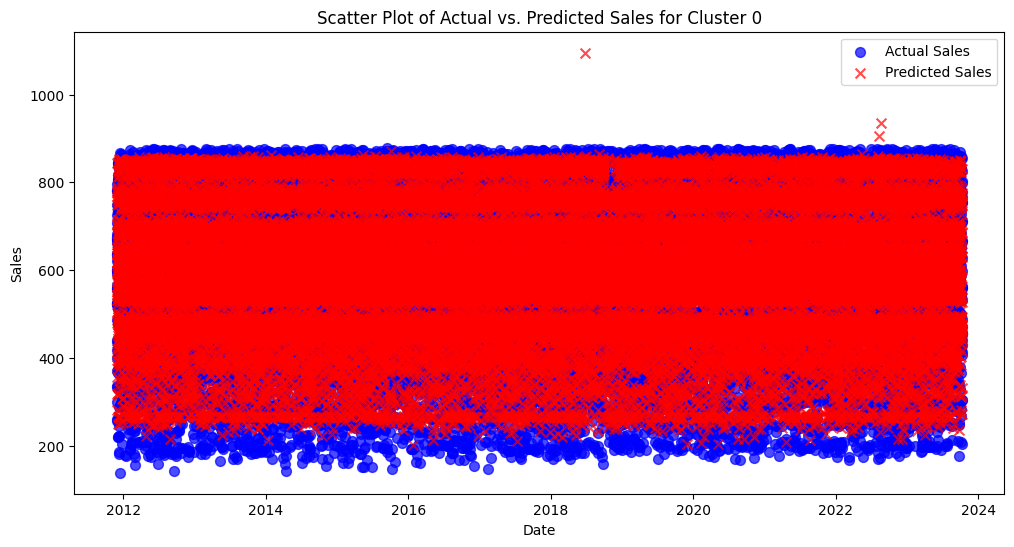

C:\Users\asus\AppData\Local\Temp\ipykernel_21456\801907302.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f'Lag_{i}'] = train['total_dollar_price'].shift(i)
C:\Users\asus\AppData\Local\Temp\ipykernel_21456\801907302.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[f'Lag_{i}'] = test['total_dollar_price'].shift(i)
C:\Users\asus\AppData\Local\Temp\ipykernel_21456\801907302.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

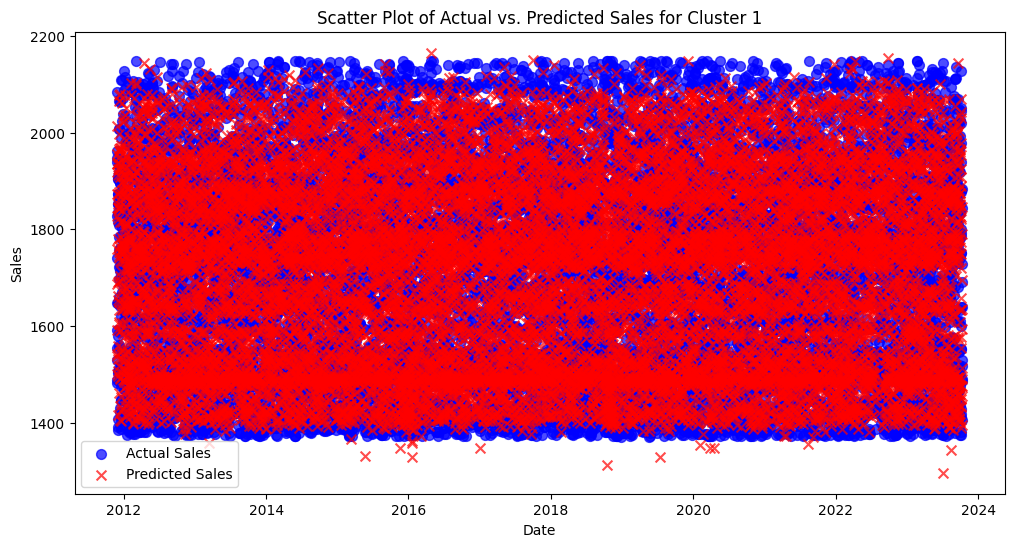

C:\Users\asus\AppData\Local\Temp\ipykernel_21456\801907302.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f'Lag_{i}'] = train['total_dollar_price'].shift(i)
C:\Users\asus\AppData\Local\Temp\ipykernel_21456\801907302.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[f'Lag_{i}'] = test['total_dollar_price'].shift(i)
C:\Users\asus\AppData\Local\Temp\ipykernel_21456\801907302.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

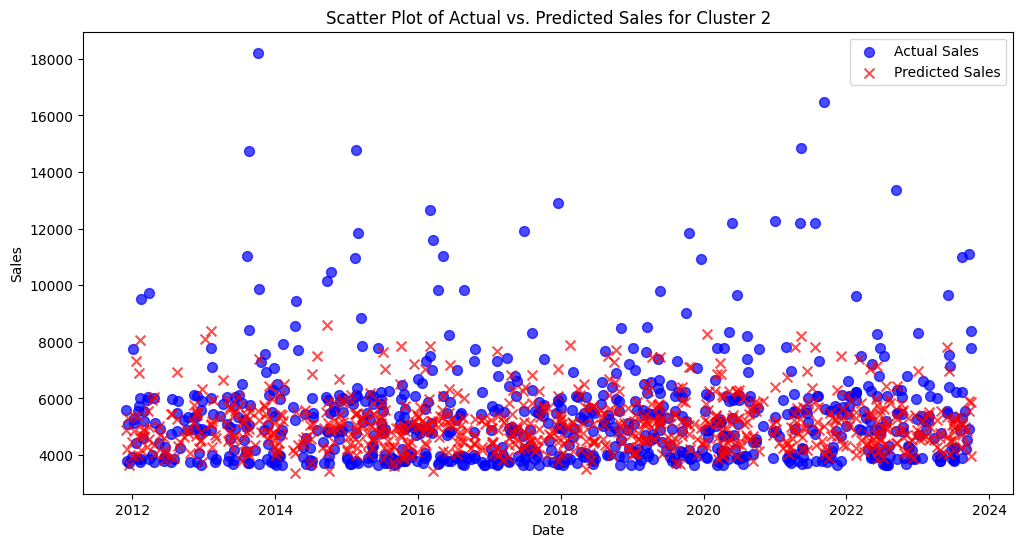

C:\Users\asus\AppData\Local\Temp\ipykernel_21456\801907302.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f'Lag_{i}'] = train['total_dollar_price'].shift(i)
C:\Users\asus\AppData\Local\Temp\ipykernel_21456\801907302.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[f'Lag_{i}'] = test['total_dollar_price'].shift(i)
C:\Users\asus\AppData\Local\Temp\ipykernel_21456\801907302.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

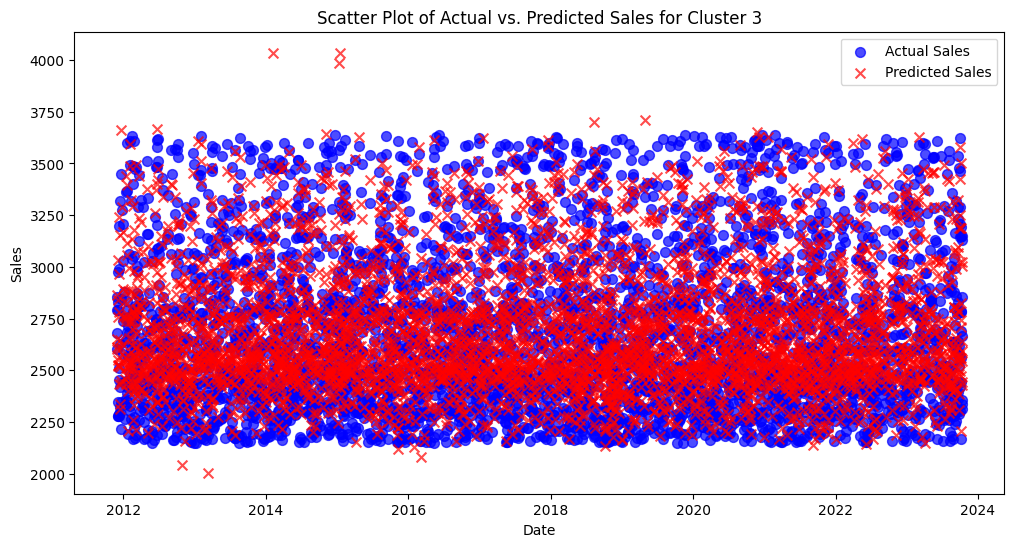

C:\Users\asus\AppData\Local\Temp\ipykernel_21456\801907302.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f'Lag_{i}'] = train['total_dollar_price'].shift(i)
C:\Users\asus\AppData\Local\Temp\ipykernel_21456\801907302.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[f'Lag_{i}'] = test['total_dollar_price'].shift(i)
C:\Users\asus\AppData\Local\Temp\ipykernel_21456\801907302.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

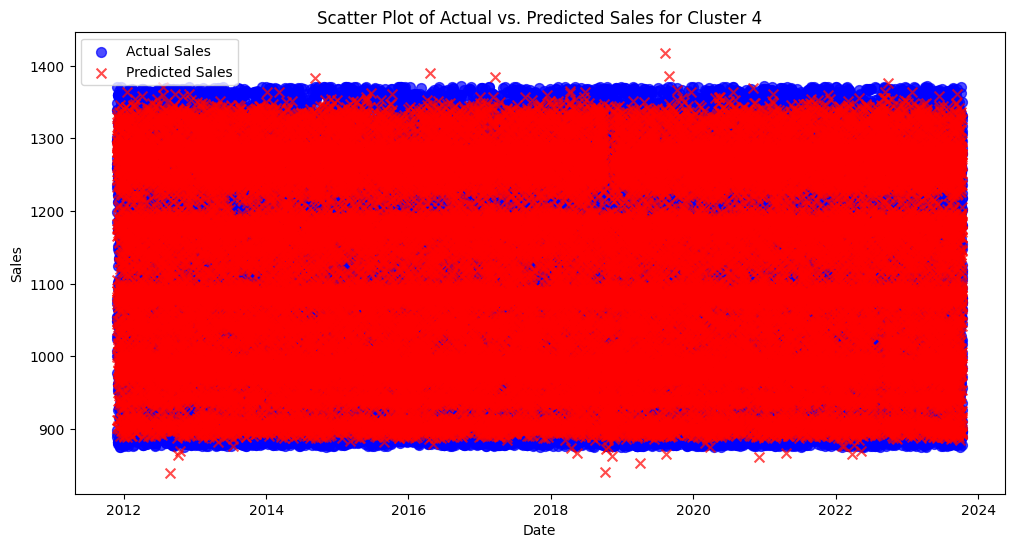

In [101]:
import pandas as pd
import numpy as np
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'df' with columns: 'Year', 'Month', 'Day', 'Cluster', and 'total_dollar_price'.

df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

for selected_cluster in range(5):
    cluster_sales_data = df[df['Cluster'] == selected_cluster]

    ts_data = cluster_sales_data[['Date', 'total_dollar_price']]
    ts_data.set_index('Date', inplace=True)

    train_size = int(0.8 * len(ts_data))
    train, test = ts_data.iloc[:train_size], ts_data.iloc[train_size:]

    for i in range(1, 13):
        train[f'Lag_{i}'] = train['total_dollar_price'].shift(i)
        test[f'Lag_{i}'] = test['total_dollar_price'].shift(i)

    train.dropna(inplace=True)
    test.dropna(inplace=True)

    X_train = train.drop(columns=['total_dollar_price'])
    y_train = train['total_dollar_price']
    X_test = test.drop(columns=['total_dollar_price'])
    y_test = test['total_dollar_price']

    model = xgb.XGBRegressor(objective="reg:squarederror")
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    plt.figure(figsize=(12, 6))
    plt.scatter(test.index, test['total_dollar_price'], label='Actual Sales', color='blue', s=50, marker='o', alpha=0.7)
    plt.scatter(test.index, predictions, label='Predicted Sales', color='red', s=50, marker='x', alpha=0.7)
    plt.legend()
    plt.title(f'Scatter Plot of Actual vs. Predicted Sales for Cluster {selected_cluster}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()


<h2 align=left style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Request 9
</h2>

In [29]:
# Enter the following values to connect to the database
user = "root"
password = "root"
host = "localhost"
port = 3306
database = "project"

engine = create_engine(
    url="mysql+pymysql://{0}:%s@{1}/{2}".format(user, host, database)
    % quote_plus(password)
)

# Get data from data base
query = """
SELECT
    p.id AS product_id,
    cpus.model AS cpu_model,
    cpus.Frequency AS frequency,
    gpus.model AS gpu_model,
    manufacturers.name AS manufacturer,
    oss.Name AS oss,
    rams.Size AS ram_size,
    screens.size AS screen_size,
    screens.Resolution As resolution,
    storages.model AS storage_model,
    categories.name AS category,
    prices.total_price AS total_price,
    prices.Quantity As quantity,
    spec.Weight As weight
FROM
    products p
JOIN
    specs  AS spec ON p.spec_id = spec.ID
JOIN
    cpus ON spec.CPU_ID = cpus.ID
JOIN
    gpus ON spec.GPU_ID = gpus.ID
JOIN
    manufacturers ON p.Manufacturer_ID = manufacturers.ID
JOIN
    oss ON spec.OS_ID = oss.ID
JOIN
    rams ON spec.RAM_ID = rams.ID
JOIN
    screens ON spec.Screen_ID = screens.ID

JOIN
    storages ON spec.Storage_ID = storages.ID
JOIN
    categories ON p.category_id = categories.id
JOIN
    prices ON p.ID = prices.Product_ID;
"""
query_dollar = """
SELECT
    p.id AS product_id,
    cpus.model AS cpu_model,
    cpus.Frequency AS frequency,
    gpus.model AS gpu_model,
    manufacturers.name AS manufacturer,
    oss.Name AS oss,
    rams.Size AS ram_size,
    screens.size AS screen_size,
    screens.Resolution As resolution,
    storages.model AS storage_model,
    categories.name AS category,
    prices.total_price AS total_price,
    prices.Quantity As quantity,
    prices.total_price / prices.Dollar_Price As total_dollar_price,
    spec.Weight As weight
FROM
    products p
JOIN
    specs  AS spec ON p.spec_id = spec.ID
JOIN
    cpus ON spec.CPU_ID = cpus.ID
JOIN
    gpus ON spec.GPU_ID = gpus.ID
JOIN
    manufacturers ON p.Manufacturer_ID = manufacturers.ID
JOIN
    oss ON spec.OS_ID = oss.ID
JOIN
    rams ON spec.RAM_ID = rams.ID
JOIN
    screens ON spec.Screen_ID = screens.ID

JOIN
    storages ON spec.Storage_ID = storages.ID
JOIN
    categories ON p.category_id = categories.id
JOIN
    prices ON p.ID = prices.Product_ID;
"""
df_req_nine = pd.read_sql_query(query, engine)
df_req_nine_dollar = pd.read_sql_query(query_dollar, engine)
df_req_nine

# Labeling Object Data
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
object_columns = ['cpu_model', 'gpu_model', 'manufacturer', 'oss', 'resolution', 'storage_model', 'category']

label_mappings = {}


for column in object_columns:
    label_encoders[column] = LabelEncoder()
    df_req_nine_dollar[column] = label_encoders[column].fit_transform(df_req_nine_dollar[column])

    label_mappings[column] = dict(zip(label_encoders[column].classes_, label_encoders[column].transform(label_encoders[column].classes_)))


for column in object_columns:
    label_encoders[column] = LabelEncoder()
    df_req_nine[column] = label_encoders[column].fit_transform(df_req_nine[column])

    label_mappings[column] = dict(zip(label_encoders[column].classes_, label_encoders[column].transform(label_encoders[column].classes_)))


df_req_nine_dollar

,product_id,cpu_model,frequency,gpu_model,manufacturer,oss,ram_size,screen_size,resolution,storage_model,category,total_price,quantity,total_dollar_price,weight
0,131,40,1.3,51,1,6,8,12.0,7,28,4,18915000,1,1484.3443,0.92
1,131,40,1.3,51,1,6,8,12.0,7,28,4,5150000,1,1572.5191,0.92
2,131,40,1.3,51,1,6,8,12.0,7,28,4,5200000,1,1504.6296,0.92
3,131,40,1.3,51,1,6,8,12.0,7,28,4,37300000,1,1476.9937,0.92
4,131,40,1.3,51,1,6,8,12.0,7,28,4,5700000,1,1524.0642,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508501,926,59,2.7,31,2,5,64,17.3,3,11,1,12900000,1,3993.8080,3.58
508502,926,59,2.7,31,2,5,64,17.3,3,11,1,11700000,1,3968.7924,3.58
508503,926,59,2.7,31,2,5,64,17.3,3,11,1,46100000,1,4097.7778,3.58
508504,926,59,2.7,31,2,5,64,17.3,3,11,1,13965000,1,3892.1405,3.58


In [78]:
print("-----------------------------------------------------------------------------------------------------------------------------------")
print("<Feature Importance on Total Price - Rial>")
#  Feature Importance on Total Price
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = df_req_nine.drop(columns=['total_price'])  
y = df_req_nine['total_price']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

feature_importance = model.coef_ / (model.coef_.sum()) * 100
feature_names = X.columns

for name, importance in zip(feature_names, feature_importance):
    print(f"{name} : {importance:.2f}%")

print("In linear regression, negative coefficients indicate a negative relationship between the corresponding feature and the Total_price")
print("-----------------------------------------------------------------------------------------------------------------------------------")
print("<Feature Importance on Total Price - Rial>")
#  Feature Importance on Total Price
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = df_req_nine.drop(columns=['quantity'])  
y = df_req_nine['quantity']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

feature_importance = model.coef_ / (model.coef_.sum()) * 100
feature_names = X.columns

for name, importance in zip(feature_names, feature_importance):
    print(f"{name} : {importance:.2f}%")

print("In linear regression, negative coefficients indicate a negative relationship between the corresponding feature and the quantity")


print("-----------------------------------------------------------------------------------------------------------------------------------")
print("<Feature Importance on Total Price - Dollar>")
#  Feature Importance on Total Price
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = df_req_nine_dollar.drop(columns=['total_dollar_price'])  
y = df_req_nine_dollar['total_dollar_price']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

feature_importance = model.coef_ / (model.coef_.sum()) * 100
feature_names = X.columns

for name, importance in zip(feature_names, feature_importance):
    print(f"{name} : {importance:.2f}%")


print("In linear regression, negative coefficients indicate a negative relationship between the corresponding feature and the Total_price")
print("-----------------------------------------------------------------------------------------------------------------------------------")
print("<Feature Importance on Total Price - Dollar>")
#  Feature Importance on Total Price
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = df_req_nine_dollar.drop(columns=['quantity'])  
y = df_req_nine_dollar['quantity']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

feature_importance = model.coef_ / (model.coef_.sum()) * 100
feature_names = X.columns

for name, importance in zip(feature_names, feature_importance):
    print(f"{name} : {importance:.2f}%")

print("In linear regression, negative coefficients indicate a negative relationship between the corresponding feature and the quantity")

-----------------------------------------------------------------------------------------------------------------------------------
<Feature Importance on Total Price - Rial>
product_id : 0.01%
cpu_model : 0.52%
frequency : 11.08%
gpu_model : -0.08%
manufacturer : 0.79%
oss : 5.30%
ram_size : 4.15%
screen_size : -5.73%
resolution : 2.97%
storage_model : 0.41%
category : 1.60%
quantity : 78.35%
weight : 0.62%
In linear regression, negative coefficients indicate a negative relationship between the corresponding feature and the Total_price
-----------------------------------------------------------------------------------------------------------------------------------
<Feature Importance on Total Price - Rial>
product_id : 0.05%
cpu_model : 2.74%
frequency : 58.11%
gpu_model : -0.56%
manufacturer : 4.41%
oss : 22.09%
ram_size : 21.35%
screen_size : -28.83%
resolution : 17.77%
storage_model : 2.18%
category : 2.47%
total_price : -0.00%
weight : -1.77%
In linear regression, negative coeffi

In [72]:
# Hypothesis 1 : Total Price Vs. Quantity
from scipy.stats import linregress
import statsmodels.api as sm
from statsmodels.formula.api import ols

slope, intercept, r_value, p_value, std_err = linregress(df_req_nine['total_price'], df_req_nine['quantity'])

if p_value < 0.05:  
    print("H1: Total Price has a significant impact on Quantity.")
else:
    print("H1: Total Price does not have a significant impact on Quantity.")


# Hypothesis 2: Frequency Vs. Quantity
slope, intercept, r_value, p_value, std_err = linregress(df_req_nine['frequency'], df_req_nine['quantity'])

if p_value < 0.05:  
    print("H2: Frequency has a significant impact on Quantity.")
else:
    print("H2: Frequency does not have a significant impact on Quantity.")


# Hypothesis 3: Screen Size Vs. Total Price
slope, intercept, r_value, p_value, std_err = linregress(df_req_nine['screen_size'], df_req_nine['total_price'])

if p_value < 0.05:  
    print("H3: Screen Size has a significant impact on Total Price.")
else:
    print("H3: Screen Size does not have a significant impact on Total Price.")



# Hypothesis 4: Oss Vs. Quantity / Total Price

model = ols('quantity ~ C(oss) + total_price', data=df_req_nine).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

oss_p_value = anova_table.loc['C(oss)', 'PR(>F)']

if oss_p_value < 0.05:
    print("H4: At least one OSS category has a significant impact on Quantity, controlling for Total Price.")
else:
    print("H4: OSS does not have a significant impact on Quantity, controlling for Total Price.")


# Hypothesis 5: Category Vs. Total Price 
model = ols('total_price ~ C(category) + quantity', data=df_req_nine).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
category_p_value = anova_table.loc['C(category)', 'PR(>F)']

if category_p_value < 0.05:
    print("H5: At least one Category has a significant impact on Total Price, controlling for Quantity.")
else:
    print("H5: Category does not have a significant impact on Total Price, controlling for Quantity.")


# Hypothesis 6: Category Vs. Quantity
groups = [df_req_nine[df_req_nine['category'] == category]['quantity'] for category in df_req_nine['category'].unique()]
f_statistic, p_value = f_oneway(*groups)

if p_value < 0.05:
    print("H6: At least one Category has a significant impact on Quantity.")
else:
    print("H6: Category does not have a significant impact on Quantity.")

H1: Total Price has a significant impact on Quantity.
H2: Frequency does not have a significant impact on Quantity.
H3: Screen Size has a significant impact on Total Price.
H4: At least one OSS category has a significant impact on Quantity, controlling for Total Price.
H5: At least one Category has a significant impact on Total Price, controlling for Quantity.
H6: Category does not have a significant impact on Quantity.


## DataBase

In [6]:
# Enter the following values to connect to the database
user = "root"
password = "root"
host = "localhost"
port = 3306
database = "project"

engine = create_engine(
    url="mysql+pymysql://{0}:%s@{1}/{2}".format(user, host, database)
    % quote_plus(password)
)

In [ ]:
query = """
SELECT
    M.Name AS Manufacturer,
    P.Name,
    C.Name AS Category,
    R.Size AS RAM,
    S.Model AS Storage,
    Sp.Weight,
    CPU_M.Name AS CPU_Manufacturer,
    CPU.Model AS CPU_Model,
    CPU.Frequency AS CPU_Freq,
    GPU_M.Name AS GPU_Manufacturer,
    GPU.Model AS GPU_Model,
    OS.Name AS OS_Name,
    OS.Version AS OS_Version,
    Sc.Size AS Screen_Size,
    Sc.Resolution AS Screen_Resolution,
    Sc.Type AS Screen_Type,
#     Prc.Price,
#     Prc.Dollar_Price,
#     Prc.Price / Prc.Dollar_Price AS Real_Price,
    AVG(Prc.Price / Prc.Dollar_Price) OVER (PARTITION BY P.ID) AS Average_Real_Price
FROM
    Prices Prc
JOIN
    Products P ON Prc.Product_ID = P.ID
LEFT JOIN
    Manufacturers M ON P.Manufacturer_ID = M.ID
LEFT JOIN
    Categories C ON P.Category_ID = C.ID
LEFT JOIN
    Specs Sp ON P.Spec_ID = Sp.ID
LEFT JOIN
    RAMs R ON Sp.RAM_ID = R.ID
LEFT JOIN
    Storages S ON Sp.Storage_ID = S.ID
LEFT JOIN
    CPUs CPU ON Sp.CPU_ID = CPU.ID
LEFT JOIN
    Manufacturers CPU_M ON CPU.Manufacturer_ID = CPU_M.ID
LEFT JOIN
    GPUs GPU ON Sp.GPU_ID = GPU.ID
LEFT JOIN
    Manufacturers GPU_M ON GPU.Manufacturer_ID = GPU_M.ID
LEFT JOIN
    OSs OS ON Sp.OS_ID = OS.ID
LEFT JOIN
    Screens Sc ON Sp.Screen_ID = Sc.ID
group by P.ID;
"""

df = pd.read_sql_query(query, engine)
df

In [8]:
query = """
SELECT
    P.Discount,
    P.Quantity,
    O.Date AS Order_Date,
    P.Profit,
    P.Dollar_Price,
    M.Name AS Manufacturer,
    C.Name AS Category
FROM
    Orders O
JOIN
    Prices P ON O.Price_ID = P.ID
JOIN
    Products Pr ON P.Product_ID = Pr.ID
JOIN
    Manufacturers M ON Pr.Manufacturer_ID = M.ID
JOIN
    Categories C ON Pr.Category_ID = C.ID;
"""

df = pd.read_sql_query(query, engine)
df

,Discount,Quantity,Order_Date,Profit,Dollar_Price,Manufacturer,Category
0,0,1,2018-01-16,250000,4448,Dell,Notebook
1,0,1,2013-11-17,260000,3003,Dell,Notebook
2,0,1,2020-08-25,1740000,22996,Dell,Notebook
3,0,1,2018-05-19,580000,6201,Dell,Notebook
4,0,1,2015-10-14,260000,3388,Dell,Notebook
...,...,...,...,...,...,...,...
508151,0,1,2016-07-28,80000,3544,Acer,Netbook
508152,0,1,2013-09-27,80000,3040,Acer,Netbook
508153,0,1,2020-11-16,820000,25897,Acer,Netbook
508154,0,1,2017-09-03,130000,3879,Acer,Netbook
